## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 6.64 and accuracy of 0.031
Iteration 100: with minibatch training loss = 1.26 and accuracy of 0.2
Iteration 200: with minibatch training loss = 0.639 and accuracy of 0.36
Iteration 300: with minibatch training loss = 0.592 and accuracy of 0.33
Iteration 400: with minibatch training loss = 0.518 and accuracy of 0.42
Iteration 500: with minibatch training loss = 0.568 and accuracy of 0.27
Iteration 600: with minibatch training loss = 0.482 and accuracy of 0.34
Iteration 700: with minibatch training loss = 0.576 and accuracy of 0.27
Epoch 1, Overall loss = 0.737 and accuracy of 0.314


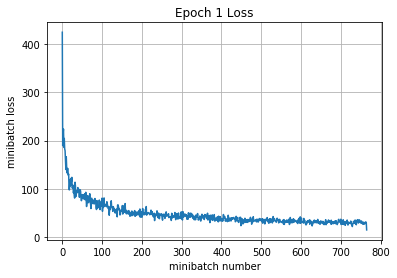

Validation
Epoch 1, Overall loss = 0.478 and accuracy of 0.374


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# Use this (https://stackoverflow.com/a/56511889) to avoid error: 
# `Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed 
# to initialize, so try looking to see if a warning log message was printed above.`
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    with tf.device("gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [5]:
train_step

<tf.Operation 'Adam' type=NoOp>

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* (1) 7x7 Convolutional Layer with 32 filters and stride of 1
* (2) ReLU Activation Layer
* (3) Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* (4) 2x2 Max Pooling layer with a stride of 2
* (5) Affine layer with 1024 output units
* (6) ReLU Activation Layer
* (7) Affine layer from 1024 input units to 10 outputs



In [6]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)


def batch_norm(X, mean, variance, beta, gamma, ewma_trainer, epsilon, is_training):
    # https://stackoverflow.com/a/33950177
    def train():
        X_mean, X_variance = tf.nn.moments(X, [0, 1, 2])
        assign_mean = mean #.assign(X_mean)
        assign_variance = variance #.assign(X_variance)
        with tf.control_dependencies([assign_mean, assign_variance]):
            return tf.nn.batch_norm_with_global_normalization(
                X, X_mean, X_variance, beta, gamma, epsilon, True
            )
    def test():
        # X_mean = ewma_trainer.average(mean)
        # X_variance = ewma_trainer.average(variance)

        X_mean, X_variance = tf.nn.moments(X, [0, 1, 2])
        local_beta = tf.identity(beta)
        local_gamma = tf.identity(gamma)
        return tf.nn.batch_norm_with_global_normalization(
                X, X_mean, X_variance, local_beta, local_gamma, epsilon, True
            )
    return tf.cond(is_training, train, test)
        
    
# define model
def complex_model(X,y,is_training):
    # Formula to calculate output shape of conv layer.
    # out: Output data, of shape (N, F, H', W') where H' and W' are given by
    # H' = 1 + (H + 2 * pad - HH) / stride
    #  W' = 1 + (W + 2 * pad - WW) / stride
    
    # Formula to calculate output shape of pooling layer.
    # Output shape: (N, H_out, W_out, C')
    # H_out = int((H - pool_height) / stride + 1)
    # W_out = int((W - pool_width) / stride + 1)
    
    ''' Setup variables '''
    # (1)
    # Input shape: (N, 32, 32, 3)
    # Output shape : (N, 28, 28, 32)
    # H' = 1 + (32 + 2 * 1 - 7) / 1 = 28
    # W' = 1 + (32 + 2 * 1 - 7) / 1 = 28
    # C' = 32
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])

    # (3)
    # Input shape: (N, 28, 28, 32)
    # Output shape: (N, 28, 28, 32)
    mean1 = tf.Variable(tf.constant(0.0, shape=[32]), name="mean1", trainable=False)
    variance1 = tf.Variable(tf.constant(1.0, shape=[32]), name="variance1", trainable=False)
    
    beta1 = tf.get_variable("beta1", shape=[32])
    gamma1 = tf.get_variable("gamma1", shape=[32])
    
    ewma_trainer = tf.train.ExponentialMovingAverage(decay=0.99)
    # (4)
    # Input shape: (N, 28, 28, 32)
    # Output shape: (N, 14, 14, 32)
    # H_out = int((28 - 2) / 2 + 1) = 14
    # W_out = int((28 - 2) / 2 + 1) = 14
    
    # (5)
    # Input shape: (N, 14 * 14 * 32)
    # Output shape: (N, 1024)
    W1 = tf.get_variable("W1", shape=[14 * 14 * 32, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    
    # (7)
    # Input shape: (N, 1024)
    # Output shape: (N, 10)
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])
    
    ''' Define our graph '''
    out_1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding=[[0,0], [1,1], [1,1], [0,0]]) + bconv1
    out_2 = tf.nn.relu(out_1)
    out_3 = batch_norm(
        X=out_2, mean=mean1, variance=variance1,
        beta=beta1, gamma=gamma1, ewma_trainer=ewma_trainer, 
        epsilon=1e-8, is_training=is_training)
    out_4 = tf.nn.max_pool(out_3, ksize=2, strides=2, padding='SAME')
    out_4 = tf.reshape(out_4,[-1, 14 * 14 * 32])
    out_5 = tf.matmul(out_4, W1) + b1
    out_6 = tf.nn.relu(out_5)
    out_7 = tf.matmul(out_6, W2) + b2
    return out_7

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [7]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

3.02 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [8]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

2.91 ms ± 539 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [9]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = complex_model(X, y, is_training)
total_loss = tf.losses.softmax_cross_entropy(
    onehot_labels=tf.one_hot(y, 10), logits=y_out
)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(1e-3)
train_step = optimizer.minimize(mean_loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [11]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.29 and accuracy of 0.17
Iteration 100: with minibatch training loss = 2.13 and accuracy of 0.28
Iteration 200: with minibatch training loss = 1.76 and accuracy of 0.36
Iteration 300: with minibatch training loss = 1.42 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.65 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.19 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.49 and accuracy of 0.52
Epoch 1, Overall loss = 1.5 and accuracy of 0.463


(1.5036307861561677, 0.4625918367346939)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [12]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.11 and accuracy of 0.605


(1.1144189929962158, 0.605)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [15]:
# Feel free to play with this cell
import tensorflow.keras.layers as layers


def my_model(X,y,is_training):
    """ https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/vgg16.py#L40 """
    img_input = layers.Input(tensor=X)
    
    # Block 1
    x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
          img_input)
    x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Classification block
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    
    classifier_activation = None
    x = layers.Dense(10, activation=classifier_activation, name='predictions')(x)
    return x


tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(
    onehot_labels=tf.one_hot(y, 10), logits=y_out
)
mean_loss = tf.reduce_mean(total_loss)

# # l2 regularization.
# trainable_vars = tf.trainable_variables()
# l2_loss = tf.add_n([
#     tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name
# ]) * 0.001
# mean_loss += l2_loss

optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(mean_loss)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.89 and accuracy of 0.19
Iteration 200: with minibatch training loss = 1.54 and accuracy of 0.39
Iteration 300: with minibatch training loss = 1.7 and accuracy of 0.28
Iteration 400: with minibatch training loss = 1.51 and accuracy of 0.39
Iteration 500: with minibatch training loss = 1.47 and accuracy of 0.42
Iteration 600: with minibatch training loss = 1.44 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.2 and accuracy of 0.61
Epoch 1, Overall loss = 1.62 and accuracy of 0.383


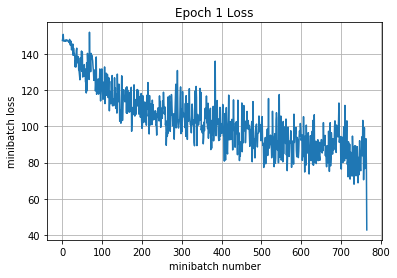

Iteration 800: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 900: with minibatch training loss = 0.892 and accuracy of 0.62
Iteration 1000: with minibatch training loss = 1.25 and accuracy of 0.55
Iteration 1100: with minibatch training loss = 1.4 and accuracy of 0.5
Iteration 1200: with minibatch training loss = 1.13 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 0.914 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 0.882 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.954 and accuracy of 0.69
Epoch 2, Overall loss = 1.13 and accuracy of 0.589


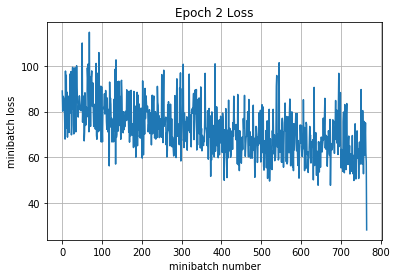

Iteration 1600: with minibatch training loss = 1.42 and accuracy of 0.5
Iteration 1700: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 1800: with minibatch training loss = 0.823 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 0.985 and accuracy of 0.62
Iteration 2000: with minibatch training loss = 0.72 and accuracy of 0.67
Iteration 2100: with minibatch training loss = 0.819 and accuracy of 0.7
Iteration 2200: with minibatch training loss = 0.805 and accuracy of 0.69
Epoch 3, Overall loss = 0.863 and accuracy of 0.696


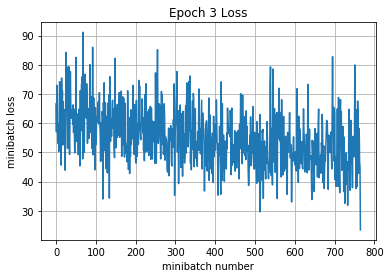

Iteration 2300: with minibatch training loss = 0.979 and accuracy of 0.7
Iteration 2400: with minibatch training loss = 0.801 and accuracy of 0.72
Iteration 2500: with minibatch training loss = 0.89 and accuracy of 0.72
Iteration 2600: with minibatch training loss = 0.748 and accuracy of 0.67
Iteration 2700: with minibatch training loss = 0.575 and accuracy of 0.81
Iteration 2800: with minibatch training loss = 0.657 and accuracy of 0.8
Iteration 2900: with minibatch training loss = 0.615 and accuracy of 0.83
Iteration 3000: with minibatch training loss = 0.516 and accuracy of 0.78
Epoch 4, Overall loss = 0.688 and accuracy of 0.76


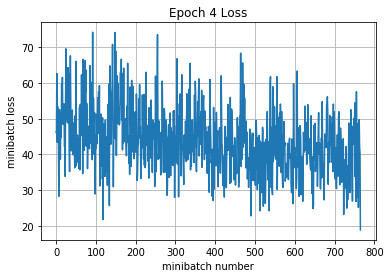

Iteration 3100: with minibatch training loss = 0.899 and accuracy of 0.69
Iteration 3200: with minibatch training loss = 0.387 and accuracy of 0.92
Iteration 3300: with minibatch training loss = 0.609 and accuracy of 0.8
Iteration 3400: with minibatch training loss = 0.389 and accuracy of 0.89
Iteration 3500: with minibatch training loss = 0.64 and accuracy of 0.8
Iteration 3600: with minibatch training loss = 0.393 and accuracy of 0.86
Iteration 3700: with minibatch training loss = 0.819 and accuracy of 0.77
Iteration 3800: with minibatch training loss = 0.506 and accuracy of 0.83
Epoch 5, Overall loss = 0.549 and accuracy of 0.811


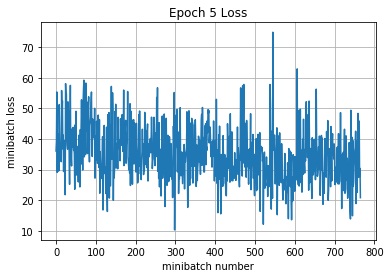

Iteration 3900: with minibatch training loss = 0.819 and accuracy of 0.73
Iteration 4000: with minibatch training loss = 0.537 and accuracy of 0.81
Iteration 4100: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 4200: with minibatch training loss = 0.454 and accuracy of 0.84
Iteration 4300: with minibatch training loss = 0.402 and accuracy of 0.86
Iteration 4400: with minibatch training loss = 0.242 and accuracy of 0.94
Iteration 4500: with minibatch training loss = 0.55 and accuracy of 0.81
Epoch 6, Overall loss = 0.434 and accuracy of 0.85


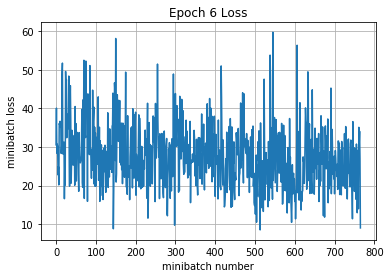

Iteration 4600: with minibatch training loss = 0.486 and accuracy of 0.83
Iteration 4700: with minibatch training loss = 0.351 and accuracy of 0.88
Iteration 4800: with minibatch training loss = 0.225 and accuracy of 0.91
Iteration 4900: with minibatch training loss = 0.454 and accuracy of 0.84
Iteration 5000: with minibatch training loss = 0.38 and accuracy of 0.88
Iteration 5100: with minibatch training loss = 0.0884 and accuracy of 0.98
Iteration 5200: with minibatch training loss = 0.194 and accuracy of 0.94
Iteration 5300: with minibatch training loss = 0.224 and accuracy of 0.95
Epoch 7, Overall loss = 0.34 and accuracy of 0.883


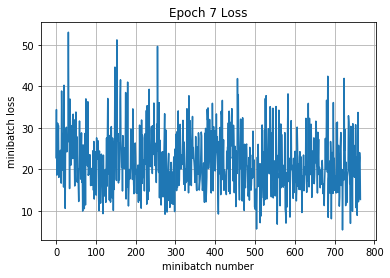

Iteration 5400: with minibatch training loss = 0.364 and accuracy of 0.86
Iteration 5500: with minibatch training loss = 0.309 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.426 and accuracy of 0.84
Iteration 5700: with minibatch training loss = 0.201 and accuracy of 0.94
Iteration 5800: with minibatch training loss = 0.277 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.737 and accuracy of 0.83
Iteration 6000: with minibatch training loss = 0.113 and accuracy of 0.97
Iteration 6100: with minibatch training loss = 0.238 and accuracy of 0.92
Epoch 8, Overall loss = 0.266 and accuracy of 0.91


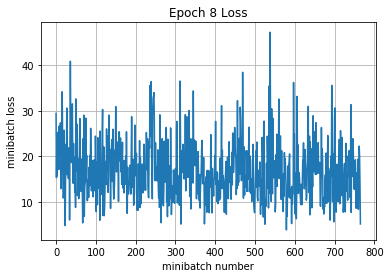

Iteration 6200: with minibatch training loss = 0.191 and accuracy of 0.97
Iteration 6300: with minibatch training loss = 0.17 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.178 and accuracy of 0.95
Iteration 6500: with minibatch training loss = 0.163 and accuracy of 0.94
Iteration 6600: with minibatch training loss = 0.249 and accuracy of 0.88
Iteration 6700: with minibatch training loss = 0.278 and accuracy of 0.92
Iteration 6800: with minibatch training loss = 0.204 and accuracy of 0.94
Epoch 9, Overall loss = 0.209 and accuracy of 0.93


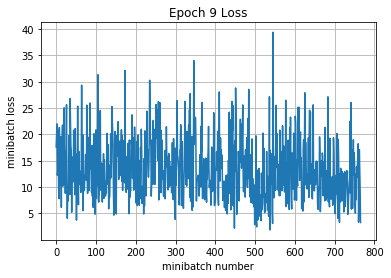

Iteration 6900: with minibatch training loss = 0.186 and accuracy of 0.91
Iteration 7000: with minibatch training loss = 0.0509 and accuracy of 1
Iteration 7100: with minibatch training loss = 0.152 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.062 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.0593 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.204 and accuracy of 0.92
Iteration 7500: with minibatch training loss = 0.443 and accuracy of 0.86
Iteration 7600: with minibatch training loss = 0.0746 and accuracy of 0.97
Epoch 10, Overall loss = 0.172 and accuracy of 0.942


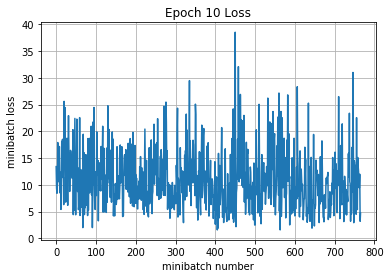

Iteration 7700: with minibatch training loss = 0.114 and accuracy of 0.97
Iteration 7800: with minibatch training loss = 0.129 and accuracy of 0.95
Iteration 7900: with minibatch training loss = 0.18 and accuracy of 0.95
Iteration 8000: with minibatch training loss = 0.116 and accuracy of 0.97
Iteration 8100: with minibatch training loss = 0.0444 and accuracy of 0.98
Iteration 8200: with minibatch training loss = 0.144 and accuracy of 0.95
Iteration 8300: with minibatch training loss = 0.247 and accuracy of 0.95
Iteration 8400: with minibatch training loss = 0.105 and accuracy of 0.98
Epoch 11, Overall loss = 0.145 and accuracy of 0.95


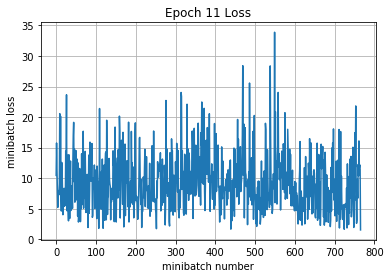

Iteration 8500: with minibatch training loss = 0.137 and accuracy of 0.95
Iteration 8600: with minibatch training loss = 0.0968 and accuracy of 0.98
Iteration 8700: with minibatch training loss = 0.133 and accuracy of 0.92
Iteration 8800: with minibatch training loss = 0.0865 and accuracy of 0.97
Iteration 8900: with minibatch training loss = 0.0867 and accuracy of 0.98
Iteration 9000: with minibatch training loss = 0.343 and accuracy of 0.88
Iteration 9100: with minibatch training loss = 0.209 and accuracy of 0.97
Epoch 12, Overall loss = 0.123 and accuracy of 0.959


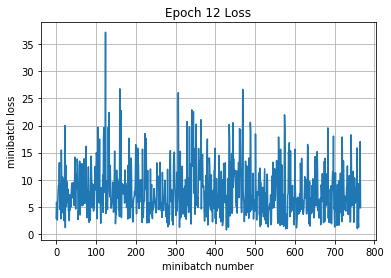

Iteration 9200: with minibatch training loss = 0.0853 and accuracy of 0.97
Iteration 9300: with minibatch training loss = 0.0691 and accuracy of 0.98
Iteration 9400: with minibatch training loss = 0.115 and accuracy of 0.95
Iteration 9500: with minibatch training loss = 0.0418 and accuracy of 0.98
Iteration 9600: with minibatch training loss = 0.153 and accuracy of 0.97
Iteration 9700: with minibatch training loss = 0.0226 and accuracy of 1
Iteration 9800: with minibatch training loss = 0.0821 and accuracy of 0.95
Iteration 9900: with minibatch training loss = 0.0859 and accuracy of 0.97
Epoch 13, Overall loss = 0.112 and accuracy of 0.964


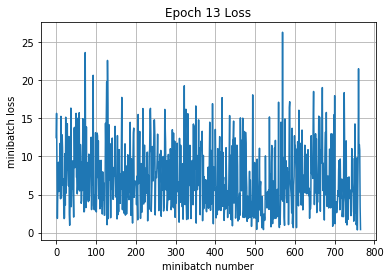

Iteration 10000: with minibatch training loss = 0.117 and accuracy of 0.94
Iteration 10100: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 10200: with minibatch training loss = 0.154 and accuracy of 0.97
Iteration 10300: with minibatch training loss = 0.0401 and accuracy of 0.98
Iteration 10400: with minibatch training loss = 0.141 and accuracy of 0.95
Iteration 10500: with minibatch training loss = 0.129 and accuracy of 0.95
Iteration 10600: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 10700: with minibatch training loss = 0.0743 and accuracy of 0.97
Epoch 14, Overall loss = 0.0977 and accuracy of 0.968


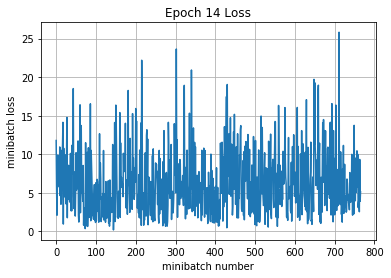

Iteration 10800: with minibatch training loss = 0.189 and accuracy of 0.97
Iteration 10900: with minibatch training loss = 0.0452 and accuracy of 0.98
Iteration 11000: with minibatch training loss = 0.171 and accuracy of 0.95
Iteration 11100: with minibatch training loss = 0.167 and accuracy of 0.94
Iteration 11200: with minibatch training loss = 0.0724 and accuracy of 0.98
Iteration 11300: with minibatch training loss = 0.0181 and accuracy of 1
Iteration 11400: with minibatch training loss = 0.277 and accuracy of 0.91
Epoch 15, Overall loss = 0.0941 and accuracy of 0.969


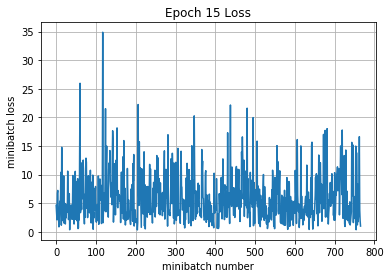

Iteration 11500: with minibatch training loss = 0.0608 and accuracy of 0.97
Iteration 11600: with minibatch training loss = 0.124 and accuracy of 0.94
Iteration 11700: with minibatch training loss = 0.0255 and accuracy of 1
Iteration 11800: with minibatch training loss = 0.0141 and accuracy of 1
Iteration 11900: with minibatch training loss = 0.0222 and accuracy of 1
Iteration 12000: with minibatch training loss = 0.178 and accuracy of 0.94
Iteration 12100: with minibatch training loss = 0.037 and accuracy of 0.98
Iteration 12200: with minibatch training loss = 0.117 and accuracy of 0.95
Epoch 16, Overall loss = 0.0851 and accuracy of 0.972


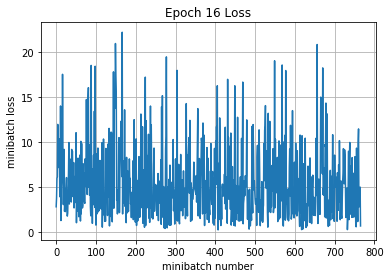

Iteration 12300: with minibatch training loss = 0.124 and accuracy of 0.95
Iteration 12400: with minibatch training loss = 0.0343 and accuracy of 0.98
Iteration 12500: with minibatch training loss = 0.0499 and accuracy of 0.98
Iteration 12600: with minibatch training loss = 0.037 and accuracy of 1
Iteration 12700: with minibatch training loss = 0.0829 and accuracy of 0.95
Iteration 12800: with minibatch training loss = 0.0305 and accuracy of 0.98
Iteration 12900: with minibatch training loss = 0.0783 and accuracy of 0.97
Iteration 13000: with minibatch training loss = 0.0907 and accuracy of 0.98
Epoch 17, Overall loss = 0.0811 and accuracy of 0.973


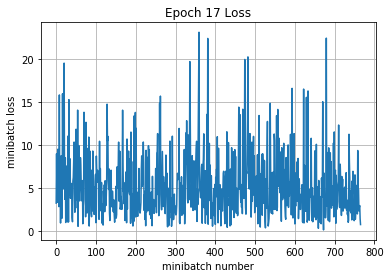

Iteration 13100: with minibatch training loss = 0.0403 and accuracy of 0.98
Iteration 13200: with minibatch training loss = 0.00461 and accuracy of 1
Iteration 13300: with minibatch training loss = 0.0607 and accuracy of 0.97
Iteration 13400: with minibatch training loss = 0.163 and accuracy of 0.97
Iteration 13500: with minibatch training loss = 0.103 and accuracy of 0.97
Iteration 13600: with minibatch training loss = 0.0721 and accuracy of 0.98
Iteration 13700: with minibatch training loss = 0.0238 and accuracy of 1
Epoch 18, Overall loss = 0.0731 and accuracy of 0.976


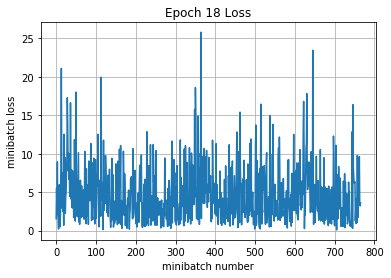

Iteration 13800: with minibatch training loss = 0.083 and accuracy of 0.97
Iteration 13900: with minibatch training loss = 0.0243 and accuracy of 0.98
Iteration 14000: with minibatch training loss = 0.086 and accuracy of 0.97
Iteration 14100: with minibatch training loss = 0.226 and accuracy of 0.97
Iteration 14200: with minibatch training loss = 0.156 and accuracy of 0.95
Iteration 14300: with minibatch training loss = 0.062 and accuracy of 0.98
Iteration 14400: with minibatch training loss = 0.0434 and accuracy of 0.98
Iteration 14500: with minibatch training loss = 0.0693 and accuracy of 0.98
Epoch 19, Overall loss = 0.0692 and accuracy of 0.978


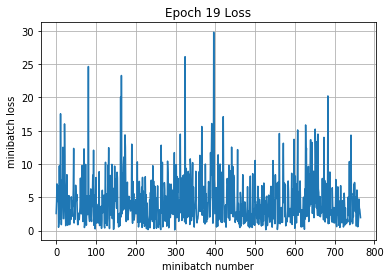

Iteration 14600: with minibatch training loss = 0.18 and accuracy of 0.97
Iteration 14700: with minibatch training loss = 0.0642 and accuracy of 0.97
Iteration 14800: with minibatch training loss = 0.0824 and accuracy of 0.98
Iteration 14900: with minibatch training loss = 0.0312 and accuracy of 1
Iteration 15000: with minibatch training loss = 0.0629 and accuracy of 0.97
Iteration 15100: with minibatch training loss = 0.00724 and accuracy of 1
Iteration 15200: with minibatch training loss = 0.0924 and accuracy of 0.97
Iteration 15300: with minibatch training loss = 0.0243 and accuracy of 1
Epoch 20, Overall loss = 0.0639 and accuracy of 0.979


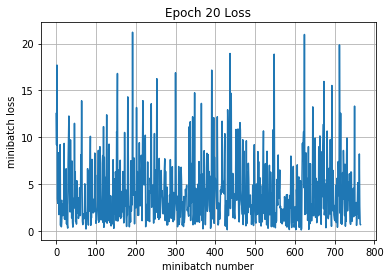

Validation
Epoch 1, Overall loss = 1.46 and accuracy of 0.773


(1.4604444160461425, 0.773)

In [16]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,20,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [18]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.0769 and accuracy of 0.976
Validation
Epoch 1, Overall loss = 1.46 and accuracy of 0.773


(1.4604443168640138, 0.773)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [19]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.41 and accuracy of 0.757


(1.4105068877220155, 0.7568)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.